<a href="https://colab.research.google.com/github/Michha02/CNN_Keras/blob/master/boat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boats CNN with Adadelta

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


boat-types-recognition	boat-types-recognition_reduced


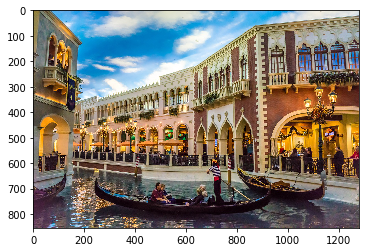

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/boat-types-recognition/train/gondola/venetian-las-vegas-gondola-canal-archite-562762.jpg', 'r')
imshow(np.asarray(pil_im))

In [0]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

Catch the dataset from Google Drive and make differents ImageDataGenerator for train and test. The final datagens have 9 classes with 150px, 150px images.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 20
train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/boat-types-recognition/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/boat-types-recognition/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Using TensorFlow backend.


Found 1019 images belonging to 9 classes.
Found 443 images belonging to 9 classes.


At this cell I create the model, first I use a convolutional layer which generates a tensor of outputs with a dimension of 148x148x32, then use a pooling layer to reduce the size to a quarter of the original one. I repeat the process one time and obtain an output of 36x36x64. At this point, I use the Dropout function with a rate of 0.25 that randomly select that fraction from the inputs and drop it, this help to reduce overfitting. Now, I apply Flatten to generate a matrix (x, 1) of my inputs. Finally, I use two Dense layers, one with 128 neurons and the other with 9 (One neuron for each type of boat), using softmax as activation funtion that returns the probability distribution of the image.

In [0]:
from keras.models import Sequential
from keras.optimizers import Adadelta
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras

# MODEL --------------------------------------------------

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Here is the resume of the model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10616960  
__________

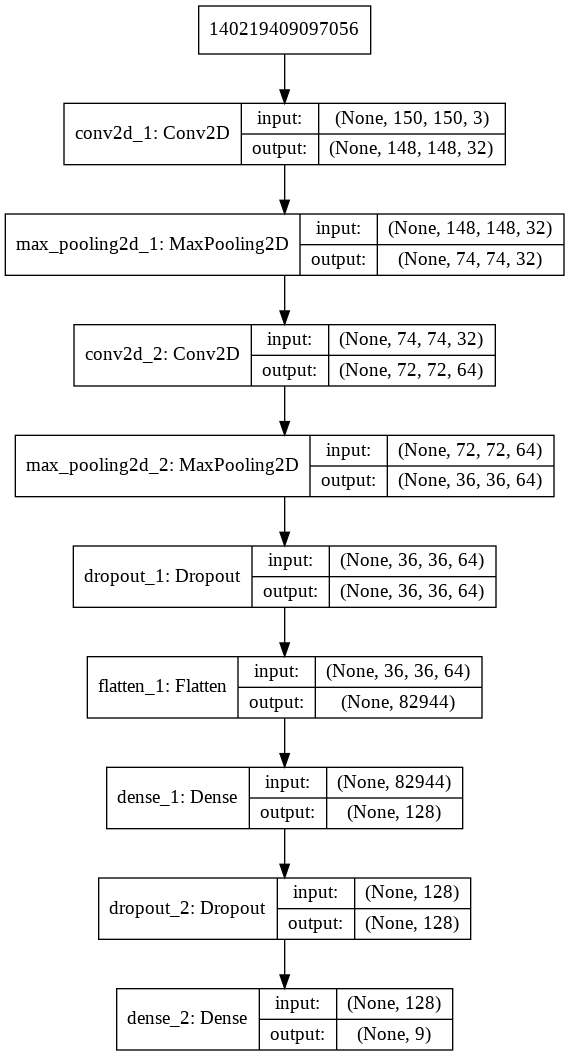

In [0]:
from keras.utils import plot_model

model.summary()
plot_model(model, to_file='./drive/My Drive/Colab Notebooks/model_plot1.png', show_shapes=True, show_layer_names=True)

Image.open('/content/drive/My Drive/Colab Notebooks/model_plot1.png')

Now, I train and test the model,  using 50 epochs with 50 steps for training and 13 for the test. I load the result in a variable named hist.

In [0]:
# TRAINING --------------------------------------------------

epochs = 50
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=1019//batch_size,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=443//32,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50/50 [==============================] - 632s 13s/step - loss: 2.1749 - acc: 0.2650 - val_loss: 1.7745 - val_acc: 0.2764
Epoch 2/50
50/50 [==============================] - 27s 545ms/step - loss: 1.8536 - acc: 0.3471 - val_loss: 1.5855 - val_acc: 0.4428
Epoch 3/50
50/50 [==============================] - 25s 495ms/step - loss: 1.7582 - acc: 0.3963 - val_loss: 1.6099 - val_acc: 0.4161
Epoch 4/50
50/50 [==============================] - 26s 525ms/step - loss: 1.6751 - acc: 0.4114 - val_loss: 1.5624 - val_acc: 0.5255
Epoch 5/50
50/50 [==============================] - 27s 532ms/step - loss: 1.6207 - acc: 0.4272 - val_loss: 1.6384 - val_acc: 0.4355
Epoch 6/50
50/50 [==============================] - 27s 536ms/step - loss: 1.5906 - acc: 0.4644 - val_loss: 1.6440 - val_acc: 0.4355
Epoch 7/50
50/50 [==============================] - 27s 533ms/step - loss: 1.4682 - acc: 0.5065 - val_loss: 1.4543 - val_acc: 0.5280
Epoch 8/50
50/50 [====

To sum up, I represent in a plot the accuracy and the loss values from training and testing to compare it.

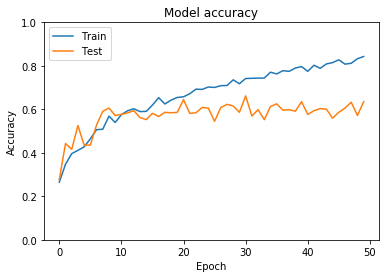

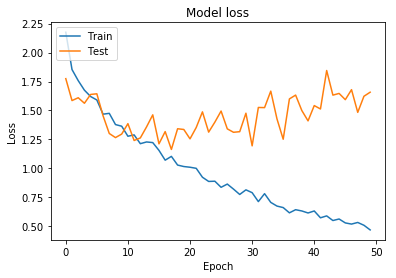

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()